<a href="https://colab.research.google.com/github/bhadreshpsavani/UnderstandingNLP/blob/master/ModelInterpretabilityAnalysisOnSimpleDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ModelInterpretabilityAnalysisOnSimpleDNN
In this notebook we will do model interpretability analysis with Captum library on titanic survival dataset

In [3]:
# install external libraries
!pip install -q captum scipy

In [4]:
import numpy as np
import pandas as pd
from scipy import stats
import torch

from captum.attr import IntegratedGradients, LayerConductance, NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [27]:
# read data
dataset_path = "https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.csv"
titanic_data = pd.read_csv(dataset_path)
titanic_data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [28]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


There are few categorical features that needs to be one hot encoded. There are also null values in few important columns like fare and boat we can replace it with average value

In [29]:
titanic_data = pd.concat([titanic_data, 
                          pd.get_dummies(titanic_data['sex']),
                          pd.get_dummies(titanic_data['embarked'],prefix="embark"),
                          pd.get_dummies(titanic_data['pclass'],prefix="class")], axis=1)
titanic_data["age"] = titanic_data["age"].fillna(titanic_data["age"].mean())
titanic_data["fare"] = titanic_data["fare"].fillna(titanic_data["fare"].mean())
titanic_data = titanic_data.drop(['name','ticket','cabin','boat','body','home.dest','sex','embarked','pclass'], axis=1)
titanic_data

,survived,age,sibsp,parch,fare,female,male,embark_C,embark_Q,embark_S,class_1,class_2,class_3
0,1,29.000000,0,0,211.3375,1,0,0,0,1,1,0,0
1,1,0.920000,1,2,151.5500,0,1,0,0,1,1,0,0
2,0,2.000000,1,2,151.5500,1,0,0,0,1,1,0,0
3,0,30.000000,1,2,151.5500,0,1,0,0,1,1,0,0
4,0,25.000000,1,2,151.5500,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,14.500000,1,0,14.4542,1,0,1,0,0,0,0,1
1305,0,29.881138,1,0,14.4542,1,0,1,0,0,0,0,1
1306,0,26.500000,0,0,7.2250,0,1,1,0,0,0,0,1
1307,0,27.000000,0,0,7.2250,0,1,1,0,0,0,0,1


In [30]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  1309 non-null   int64  
 1   age       1309 non-null   float64
 2   sibsp     1309 non-null   int64  
 3   parch     1309 non-null   int64  
 4   fare      1309 non-null   float64
 5   female    1309 non-null   uint8  
 6   male      1309 non-null   uint8  
 7   embark_C  1309 non-null   uint8  
 8   embark_Q  1309 non-null   uint8  
 9   embark_S  1309 non-null   uint8  
 10  class_1   1309 non-null   uint8  
 11  class_2   1309 non-null   uint8  
 12  class_3   1309 non-null   uint8  
dtypes: float64(2), int64(3), uint8(8)
memory usage: 61.5 KB


### Train and Test Set Split

In [31]:
# for reproducibility
np.random.seed(131254)

# get labels and feature data seperated
labels = titanic_data["survived"].to_numpy()
titanic_data = titanic_data.drop(['survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

# train test split
train_indices = np.random.choice(int(len(labels)), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels)))-set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

## Model Training and Testing

In [33]:
import torch
import torch.nn as nn
torch.manual_seed(1)
class TitanicSimpleNNModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(12, 12)
    self.sigmoid1 = nn.Sigmoid()
    self.linear2 = nn.Linear(12, 8)
    self.sigmoid2 = nn.Sigmoid()
    self.linear3 = nn.Linear(8, 2)
    self.softmax = nn.Softmax()
  def forward(self, x):
    x = self.sigmoid1(self.linear1(x))
    x = self.sigmoid2(self.linear2(x))
    x = self.softmax(self.linear3(x))
    return x

In [40]:
net = TitanicSimpleNNModel()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
label_tensor = torch.from_numpy(train_labels)

epochs = 200
for epoch in range(epochs):
  output = net(input_tensor)
  loss = criterion(output, label_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if epoch % 20 == 0:
    print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, epochs, loss.item()))
torch.save(net.state_dict(), 'titanic_model.pt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Epoch 1/200 => Loss: 0.70
Epoch 21/200 => Loss: 0.66
Epoch 41/200 => Loss: 0.64
Epoch 61/200 => Loss: 0.58
Epoch 81/200 => Loss: 0.52
Epoch 101/200 => Loss: 0.51
Epoch 121/200 => Loss: 0.50
Epoch 141/200 => Loss: 0.49
Epoch 161/200 => Loss: 0.49
Epoch 181/200 => Loss: 0.48


In [42]:
out_prob = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_prob, axis=1)
print("Train Accuracy:", sum(out_classes==train_labels)/ len(train_labels))

Train Accuracy: 0.8307860262008734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


In [45]:
test_input = torch.from_numpy(test_features).type(torch.FloatTensor)
out_prob = net(test_input).detach().numpy()
out_classes = np.argmax(out_prob, axis=1)
print("Test Accuracy:", sum(out_classes==test_labels)/ len(test_labels))

Test Accuracy: 0.811704834605598


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


## Interpreting

It is wise to get understanding of feature importance in Model. `Integrated Gradient` Can be helpful for this purpose

### Network Attribution

In [46]:
ig = IntegratedGradients(net)

In [47]:
# our input will require gradient
test_input.requires_grad_()
# attribute() is like forward method of model architecture
attr, delta = ig.attribute(test_input, target=1, return_convergence_delta=True)
# attr indicates feature importance value while delta approximates the error between the approximated integral and true integral.
attr = attr.detach().numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Average Feature Importances
age :  -0.507
sibsp :  -0.060
parch :  -0.015
fare :  0.096
female :  0.165
male :  -0.285
embark_C :  0.053
embark_Q :  0.008
embark_S :  -0.033
class_1 :  0.100
class_2 :  0.051
class_3 :  -0.247


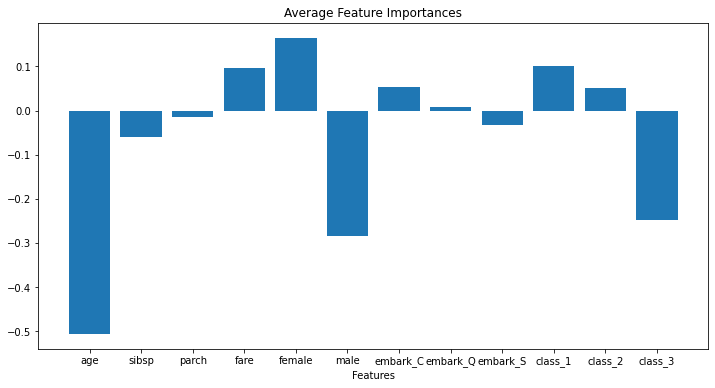

In [48]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

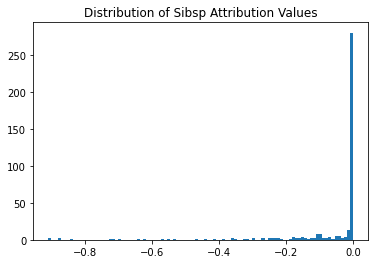

In [49]:
plt.hist(attr[:,1], 100);
plt.title("Distribution of Sibsp Attribution Values");

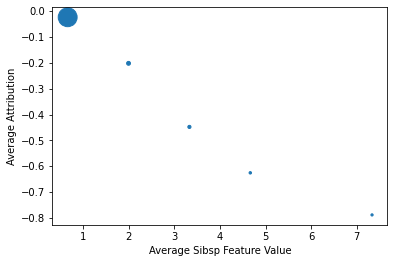

In [51]:
bin_means, bin_edges, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='mean', bins=6)
bin_count, _, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='count', bins=6)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.scatter(bin_centers, bin_means, s=bin_count)
plt.xlabel("Average Sibsp Feature Value");
plt.ylabel("Average Attribution");

### Layer Attribution:

In [52]:
cond = LayerConductance(net, net.sigmoid1)

In [53]:
cond_vals = cond.attribute(test_input,target=1)
cond_vals = cond_vals.detach().numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Average Neuron Importances
0 :  -0.068
1 :  0.032
2 :  -0.172
3 :  -0.029
4 :  -0.047
5 :  -0.071
6 :  -0.108
7 :  0.004
8 :  -0.110
9 :  0.031
10 :  -0.038
11 :  -0.097


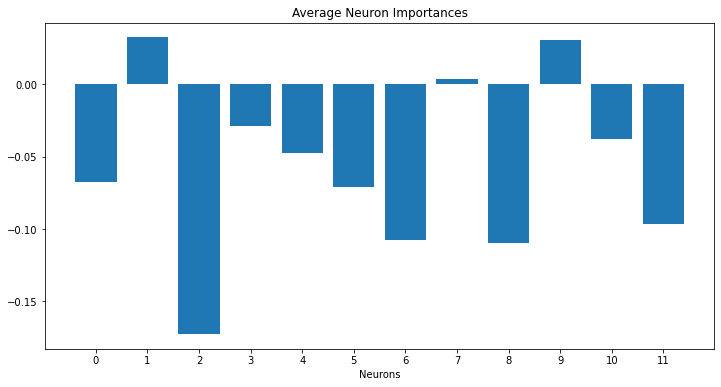

In [54]:
visualize_importances(range(12),np.mean(cond_vals, axis=0),title="Average Neuron Importances", axis_title="Neurons")

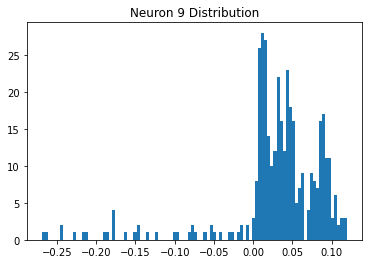

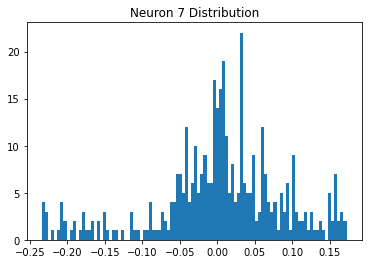

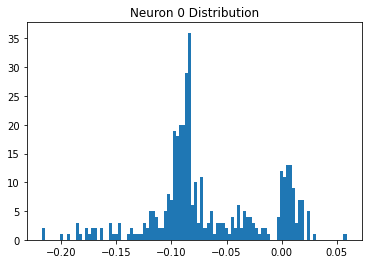

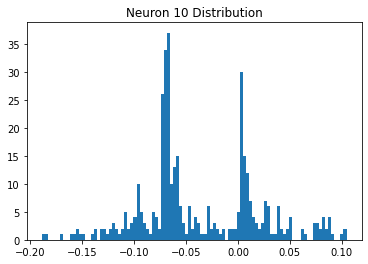

In [59]:
plt.hist(cond_vals[:,9], 100);
plt.title("Neuron 9 Distribution")
plt.figure()
plt.hist(cond_vals[:,7], 100);
plt.title("Neuron 7 Distribution");
plt.figure()
plt.hist(cond_vals[:,0], 100);
plt.title("Neuron 0 Distribution")
plt.figure()
plt.hist(cond_vals[:,10], 100);
plt.title("Neuron 10 Distribution");

### Neuron Attribution:

In [60]:
neuron_cond = NeuronConductance(net, net.sigmoid1)

In [62]:
neuron_cond_vals_10 = neuron_cond.attribute(test_input, neuron_selector=10, target=1)

neuron_cond_vals_0 = neuron_cond.attribute(test_input, neuron_selector=0, target=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Average Feature Importances for Neuron 0
age :  0.001
sibsp :  0.004
parch :  -0.008
fare :  -0.027
female :  0.020
male :  -0.044
embark_C :  0.007
embark_Q :  0.001
embark_S :  -0.010
class_1 :  0.018
class_2 :  0.002
class_3 :  -0.030


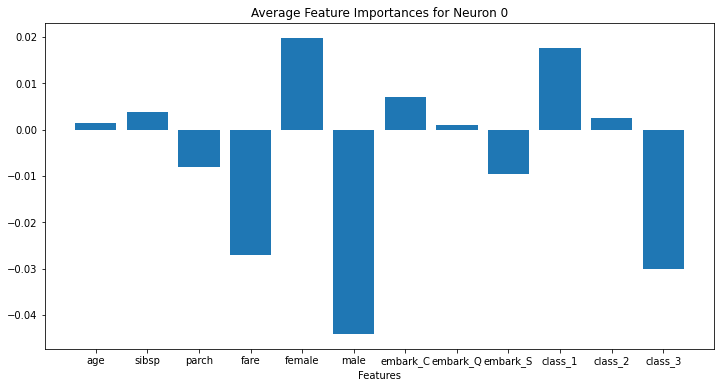

In [63]:
visualize_importances(feature_names, neuron_cond_vals_0.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 0")

Average Feature Importances for Neuron 10
age :  -0.020
sibsp :  0.007
parch :  0.006
fare :  -0.017
female :  0.016
male :  -0.035
embark_C :  0.004
embark_Q :  0.002
embark_S :  0.004
class_1 :  0.010
class_2 :  0.006
class_3 :  -0.018


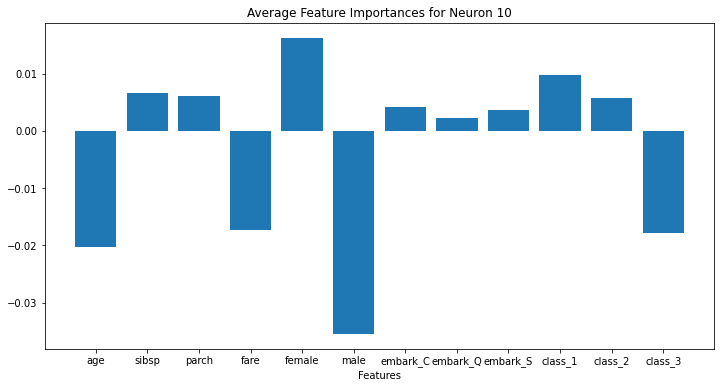

In [64]:
visualize_importances(feature_names, neuron_cond_vals_10.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 10")

### Conclusion:

Captum Allows us to interpret entire model, Layerwise Analyse and we can also do neuron based analysis.

## Reference Tutorial:
https://captum.ai/tutorials/Titanic_Basic_Interpret